# PHYS3070 Thermal Convection


<img src="images/Picture1.png" width="800">


## Steady isoviscous thermal convection

<img src="images/Picture10.png" width="800">

Steady convection with constant viscosity in a square box (l / h =1).
Temperature is fixed to zero on top and to $\Delta T$ at the bottom, no internal heat sources. Reflecting symmetry at the sidewalls, zero shear stress on all boundaries (freeslip).

In [1]:
import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /home/jovyan/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Take some known numbers / dimension about the system

In [3]:
boxHeight = 1000. * u.kilometer
boxLength = 1000. * u.kilometer
diffusivity = 1e-6 * u.metre**2 / u.second
tempMin = 273.15 * u.degK
tempMax = 1273.15 * u.degK
refViscosity = 1e23 * u.pascal * u.second

## Define Characteristic dimensions

In [4]:
characteristic_length = boxHeight
characteristic_temperature = (tempMax - tempMin)
characteristic_time = characteristic_length**2 / diffusivity
characteristic_mass = refViscosity * characteristic_length * characteristic_time

GEO.scaling_coefficients["[length]"] = characteristic_length
GEO.scaling_coefficients["[temperature]"]=characteristic_temperature
GEO.scaling_coefficients["[time]"] = characteristic_time
GEO.scaling_coefficients["[mass]"] = characteristic_mass

In [5]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer), 
                  maxCoord=(1000. * u.kilometer, 1000. * u .kilometer),
                  gravity=(0., -10. * u.meter / u.second**2))

In [6]:
Model.outputDir = "PHYS3070_Thermal_convection"

## Define Material property

We define the density of the material to be temperature dependent using a thermal expansivity of $2.5 \times 10^{-5} \text{/K}^{\circ}$. 

The diffusivity is set to $1 \times 10^6 \text{m}^2 / \text{s}$

Considering 3 subcases:
- Case 1(A): $Ra = 10^4$
- Case 1(B): $Ra = 10^5$
- Case 1(C): $Ra = 10^6$

This gives:

In [7]:
case1A = 1.0e23 * u.pascal * u.second
case1B = 1.0e22 * u.pascal * u.second
case1C = 1.0e21 * u.pascal * u.second

In [8]:
Model.density = GEO.LinearDensity(4000. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.degK)
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.viscosity = case1A

## Check Raylegh number

The Raylegh number is defined as 

$$ Ra_0 = \frac{\alpha g \Delta T h^3}{\kappa \mu_0} $$

$\alpha$ is thermal expansion coefficient,
$\kappa$ is diffusivity,
$g$ is gravity,
$dT$ is the difference in temperature between top and bottom,
$h$ is the Model height,
$mu0$.

Let's calculate the Rayleigh number and check that our material properties are correct:

In [9]:
alpha = Model.thermalExpansivity
kappa = Model.diffusivity
g = abs(Model.gravity[-1])
dT = (tempMax - tempMin)
h = Model.height
mu0 = case1A / Model.density.reference_density

Ra0 = (alpha * g * dT * h**3) / (kappa * mu0)

print("Rayleigh Number: {0:6.1f}".format(Ra0.to_base_units()))

Rayleigh Number: 10000.0 dimensionless


# Boundary Conditions

All boundaries have free-slip condition (zero shear stress):

In [10]:
VelocityBCs = Model.set_velocityBCs(left=[0., None], right=[0.,None], top=[None,0.], bottom=[None,0.])

Temperature is fixed to zero on top and to  Δ𝑇  at the bottom, no internal heat sources.

In [11]:
TemperatureBCs = Model.set_temperatureBCs(top=tempMin, bottom=tempMax)

## Initial Temperature perturbation

The initial condition is chosen in order to obtain a single convection cell in the box.

We chose a periodic perturbation:

$$\delta T_{(x,y)} = A\cos\left(\pi \frac{x}{L}\right) \sin{\left(\pi \frac{y}{H}\right)}$$

with $A$ the Amplitude of the perturbation, $L$ and $H$ the dimension of the box.

The initial condition is:

$$T_{(x,y)} = T_{\text{min}} + \Delta T(H - y) + \delta T$$ 

In [12]:
import math

boxLength = GEO.nd(boxLength)
boxHeight = GEO.nd(boxHeight)
tempMin = GEO.nd(tempMin)
tempMax = GEO.nd(tempMax)

Model.temperature.data[:] = 0.
pertStrength = GEO.nd(100. * u.kilometer)
deltaTemp = tempMax - tempMin

for index, coord in enumerate(Model.mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    Model.temperature.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    Model.temperature.data[index] = max(tempMin, min(tempMax, Model.temperature.data[index]))

/usr/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



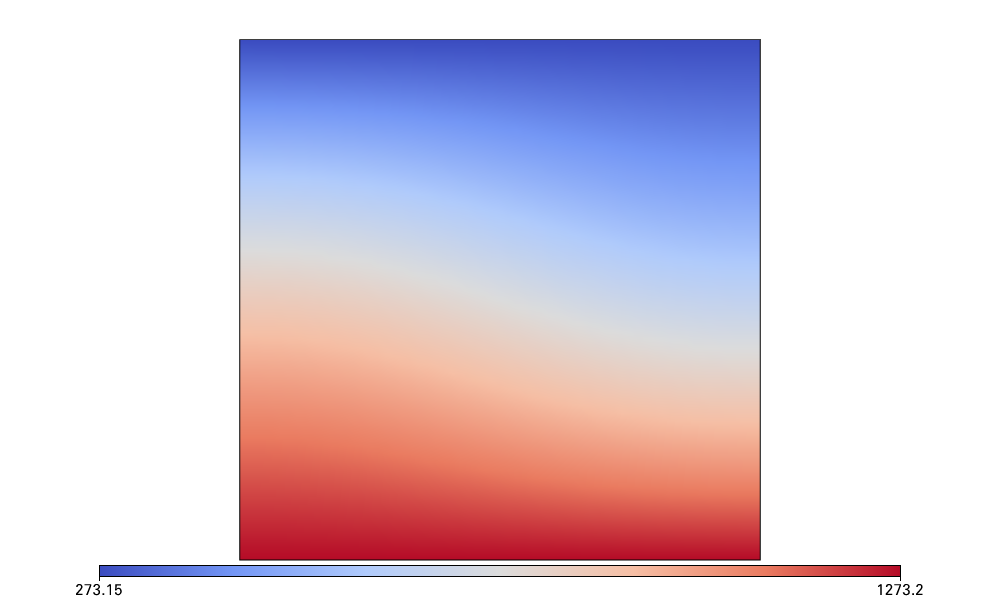

In [13]:
Fig = vis.Figure(figsize=(1000,600))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.show()

## Passive Tracers

Lets define a rectangle of passive tracers at the top left corner of the model. The tracers will advect with the material.

In [14]:
import numpy as np

width = 50. * u.km
height = 25. * u.km

x = np.random.random(size=500) * width + 50. * u.km
y = np.random.random(size=500) * height + 850. * u.km

coords = np.ndarray((500, 2))
coords[:, 0] = x
coords[:, 1] = y

rectangle_tracers = Model.add_passive_tracers(name="rectangle", vertices=coords)


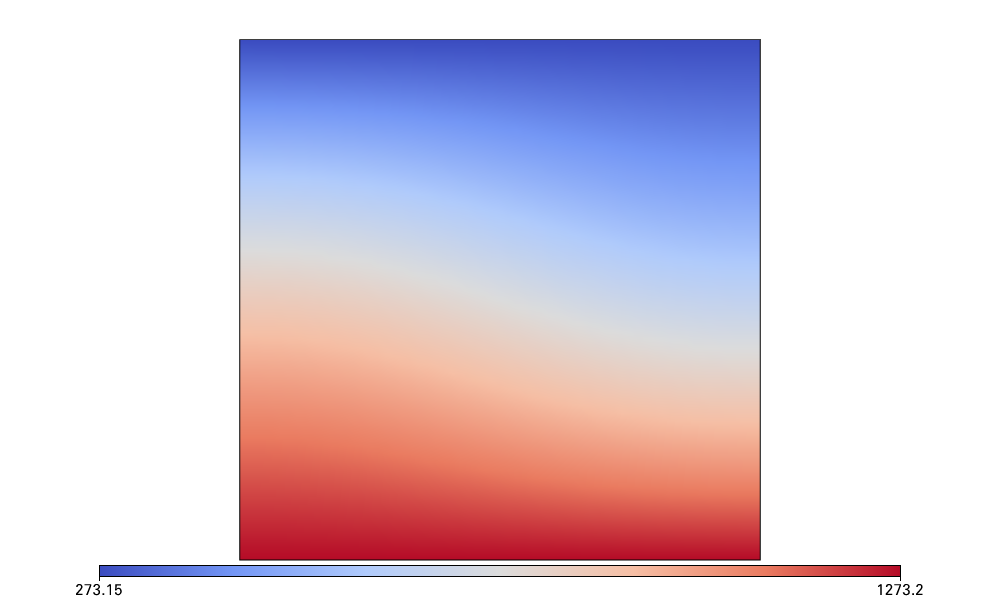

In [15]:
Fig = vis.Figure(figsize=(1000,600))
Fig.Points(rectangle_tracers, fn_size=10.0)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degK), colours="coolwarm")
Fig.show()

Analysis tools
-----

We define a set of metrics to quantatively measure the evolution of the model: 

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


We thus need to calculate 2 integrals, this can be done using the `uw.utils.Integral` Underworld function:

In [16]:
import underworld as uw

nuTop = uw.utils.Integral(fn=Model.temperature.fn_gradient[1], 
                          mesh=Model.mesh, integrationType='Surface', 
                          surfaceIndexSet=Model.top_wall)

nuBottom = uw.utils.Integral(fn=Model.temperature,               
                             mesh=Model.mesh, integrationType='Surface', 
                             surfaceIndexSet=Model.bottom_wall)

The Nusselt number is just the ratio:

In [17]:
nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]

print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 0.785453


**RMS velocity**

The root mean squared velocity is defined by intergrating over the entire simulation domain via

\\[
\begin{aligned}
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]

where $V$ denotes the volume of the box.

In [18]:
import underworld.function as fn

intVdotV = uw.utils.Integral(fn.math.dot(Model.velocityField, Model.velocityField ), Model.mesh )
vrms = math.sqrt( intVdotV.evaluate()[0] )

print('Initial vrms = {0:.3f}'.format(vrms))

Initial vrms = 0.000


Now we need to attach the functions so that they record the evolution of the Model through time. This can be done using the `Model.postSolveHook`:

## Time Analysis

In [19]:
timeVals = []
vrmsVals = []
nuVals = []

def analytics():
    
    # Calculate & store the RMS velocity and Nusselt number.
    vrms = math.sqrt( intVdotV.evaluate()[0] )
    nu   = - nuTop.evaluate()[0] / nuBottom.evaluate()[0]
    nuLast = nuVals[-1] if nuVals else nu
    
    print('v_rms = {0:.3f}; Nu = {1:.3f}; Rel change = {2:.3e}'.format(vrms, nu, abs((nu - nuLast) / nu)))
    
    vrmsVals.append(vrms)
    timeVals.append(Model.time)
    nuVals.append(nu)

In [20]:
Model.post_solve_functions["measurements"] = analytics

# Init and Run Model

In [21]:
Model.init_model(temperature=False)

In [22]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [23]:
Model.run_for(nstep=10, checkpoint_interval=1)

Running with UWGeodynamics version 2.10.0-dev-b0ccd70(new_examples)
Options:  -Q22_pc_type gkgdiag -force_correction True -ksp_type bsscr -pc_type none -ksp_k2_type NULL -rescale_equations False -remove_constant_pressure_null_space False -change_backsolve False -change_A11rhspresolve False -restore_K False -A11_ksp_type preonly -A11_pc_type lu -A11_pc_factor_mat_solver_type mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 3.9 megayear dt: 3.9 megayear (2020-06-23 03:46:55)
v_rms = 17.899; Nu = 0.787; Rel change = 0.000e+00
Step:     2 Model Time: 7.7 megayear dt: 3.9 megayear (2020-06-23 03:46:58)
v_rms = 18.153; Nu = 0.788; Rel change = 1.577e-03
Step:     3 Model Time: 11.6 megayear dt: 3.9 megayear (2020-06-23 03:47:01)
v_rms = 18.411; Nu = 0.789; Rel change = 1.616e-03
Step:     4 Model Time: 15.5 megayear dt: 3.9 megayear (2020-06-23 03:47:03)
v_rms = 18.673; Nu = 0.790; Rel change = 1.656e-03
Step:     5 Model Time: 19.3 megayear dt: 3.9

1


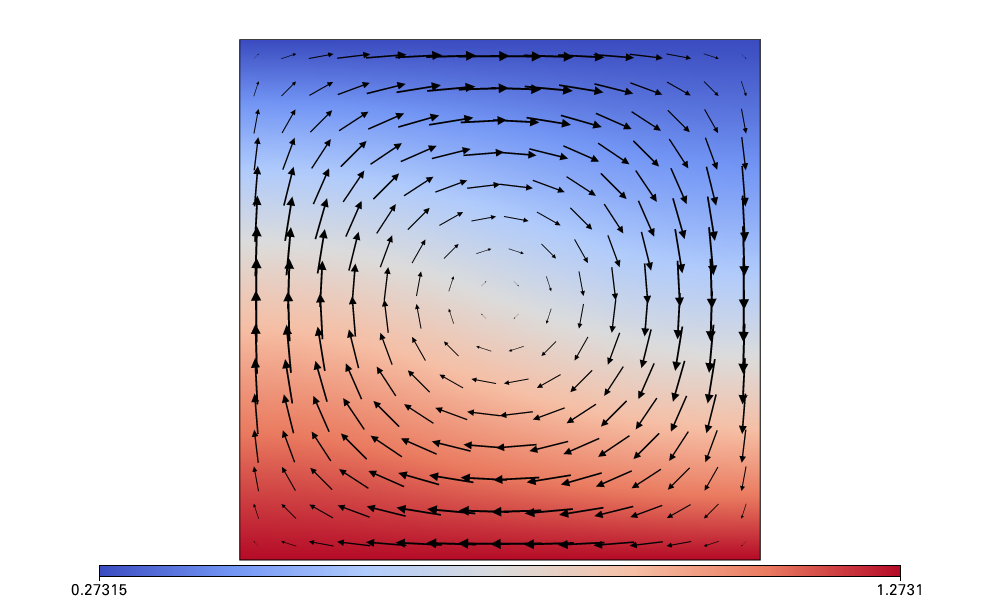

In [25]:
Fig = vis.Figure(figsize=(1000,600))
Fig.Points(Model.rectangle_tracers, fn_size=10.0)
Fig.Surface(Model.mesh, Model.temperature, colours="coolwarm")
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()

Post analysis
-----

**Benchmark values**

The time loop above outputs $v_{rms}$ and $Nu$ as general statistics for the system. For comparison, the benchmark values for the RMS velocity and Nusselt number are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 


| $Ra$          | $v_{rms}$   | $Nu$  |   $q_1$  | $q_2$  |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 |  4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |


For practicality, quick tests can be run to see that the results are close enough. Tests run using underworld gave

| $Ra$          | $v_{rms}$   | $Nu$  |
| ------------- |:-------------:|:-----:|
| 10$^4$ | 42.858 |  4.848 |
| 10$^5$ | 193.449 | 10.248 |
| 10$^6$ | 844.218 | 19.660 |
